In [1]:
# DSCC 240: Final Project "Crime, cash and COVID-19"
#Names: Grace Rico, Maria Rojas Tawil, and Jacob Freiheit 


#Linear Regression
# Make sure that when running this, you have all the file folders extracted!
# I know there are a lot of superfluous imports I have here. I included them just in case haha
import glob
import os
import pandas as pd
import plotly.express as px
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance
import geopandas as gpd
import plotly.graph_objects as go
from mlxtend.frequent_patterns import apriori, association_rules
from collections import defaultdict
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
# the next part serves the next two visuals; totals kinda control the narrative of the whole graph,
# so I made a visual for the data excluding the totals

crime_df = pd.read_excel('NYS Index Crime by County back to 2000.xlsx', header = 1)
crime_df = crime_df[crime_df['Year'] >= 2010]

In [3]:
crime_df.columns = crime_df.columns.str.strip("'")

In [4]:
crime_df = crime_df.rename(columns = {"County/Region": "County"})
print(crime_df.columns)

Index(['County', 'Year', 'Population', 'Index Total Count', 'Index Total Rate',
       'Violent Total Count', 'Violent Total Rate', 'Murder Count',
       'Murder Rate', 'Rape Count', 'Rape Rate', 'Robbery Count',
       'Robbery Rate', 'Agg Assault Count', 'Agg Assault Rate',
       'Property Total Count', 'Property Total Rate', 'Burglary Count',
       'Burglary Rate', 'Larceny Count', 'Larceny Rate', 'MV Theft Count',
       'MV Theft Rate'],
      dtype='object')


In [5]:
# altering to exclude totals and grouping crime according to county

crime_df_excluding_totals = crime_df[~crime_df['County'].isin(['NYS Total', 'NYC Total', 'Non-NYC Total'])]
county_grouped_crime_no_totals = crime_df_excluding_totals.groupby('County')
county_grouped_crime = crime_df.groupby('County')
plt.figure(figsize = (10, 10))

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

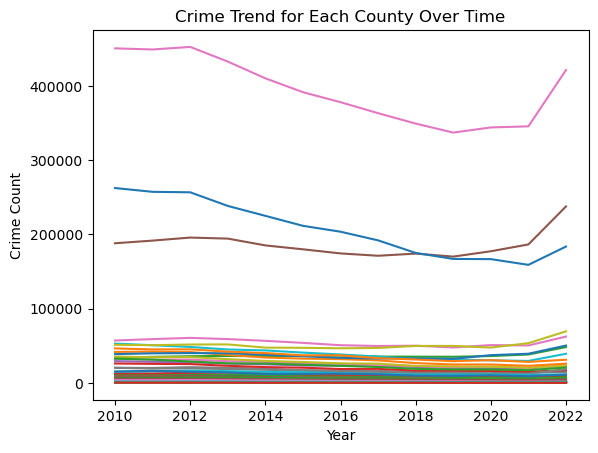

In [6]:
# plotting

for county, data in county_grouped_crime:
    plt.plot(data['Year'], data['Index Total Count'], label = county)
 
plt.xlabel('Year')
plt.ylabel('Crime Count')
plt.title('Crime Trend for Each County Over Time')
#plt.legend(loc = 'upper left', bbox_to_anchor = (1, 1))
plt.show()

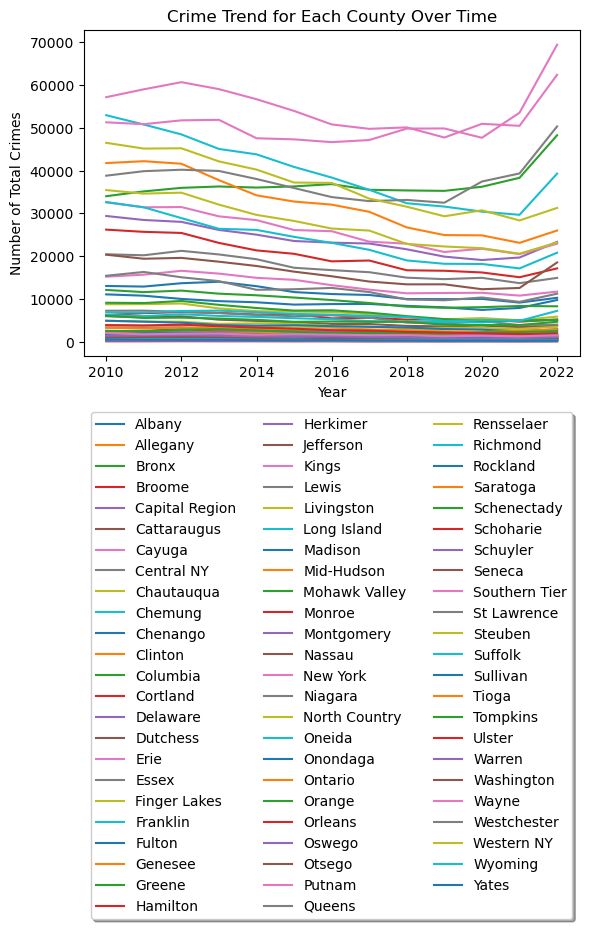

In [7]:
fig, ax = plt.subplots()
handles = []
for county, data in county_grouped_crime_no_totals:
    line, = ax.plot(data['Year'], data['Index Total Count'], label=county)
    handles.append(line)
legend = ax.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=3)
plt.subplots_adjust(bottom=0.2)
plt.xlabel('Year')
plt.ylabel('Number of Total Crimes')
plt.title('Crime Trend for Each County Over Time')
plt.show()

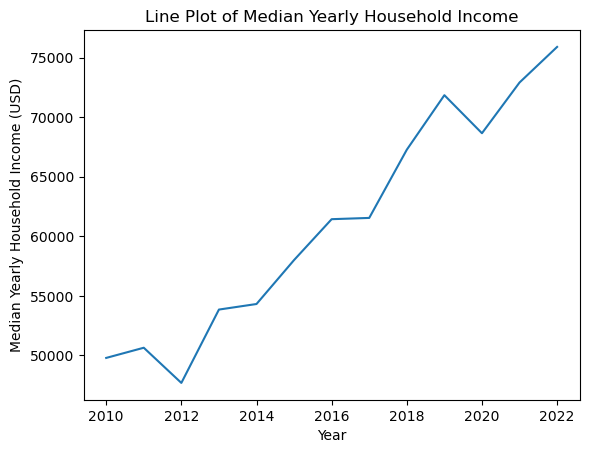

In [8]:
# same process for house income information over time

house_income_df = pd.read_excel("NYS Median Household Income.xlsx")
house_income_df = house_income_df[house_income_df['Year'] >= 2010]
plt.plot(house_income_df['Year'], house_income_df['Yearly Income'])

plt.xlabel('Year')
plt.ylabel('Median Yearly Household Income (USD)')


plt.title('Line Plot of Median Yearly Household Income')
plt.show()

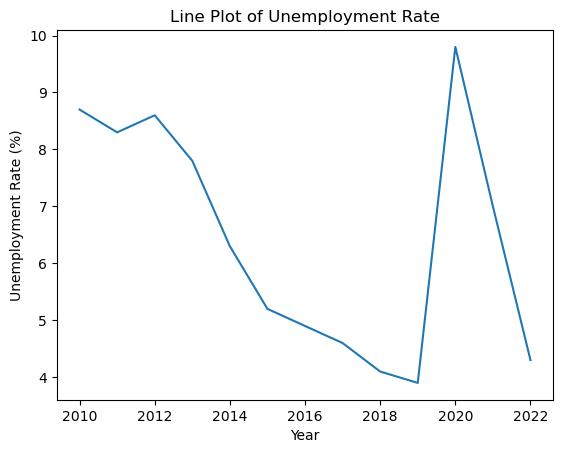

In [9]:
# same process for unemployment rate

unemployment_df = pd.read_excel("NYS Unemployment Rate.xlsx")
unemployment_df = unemployment_df[unemployment_df['Year'] >= 2010]
plt.plot(unemployment_df['Year'], unemployment_df['Rate'])

plt.xlabel('Year')
plt.ylabel('Unemployment Rate (%)')

plt.title('Line Plot of Unemployment Rate')
plt.show()

In [10]:
nys_total_data = crime_df[crime_df['County'] == 'NYS Total']

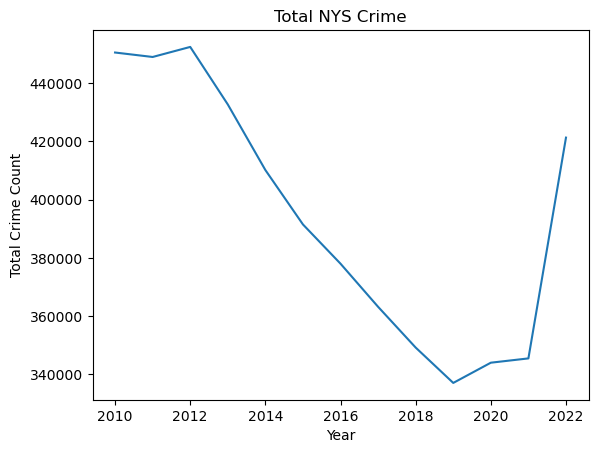

In [11]:
plt.plot(nys_total_data['Year'], nys_total_data['Index Total Count'])

plt.xlabel('Year')
plt.ylabel('Total Crime Count')

plt.title('Total NYS Crime')
plt.show()

In [12]:
crime_counts = nys_total_data[['Year', 'Murder Count', 'Rape Count', 'Robbery Count',
                               'Agg Assault Count', 'Burglary Count', 'Larceny Count', 'MV Theft Count']]

In [13]:
crime_counts.set_index('Year', inplace=True)

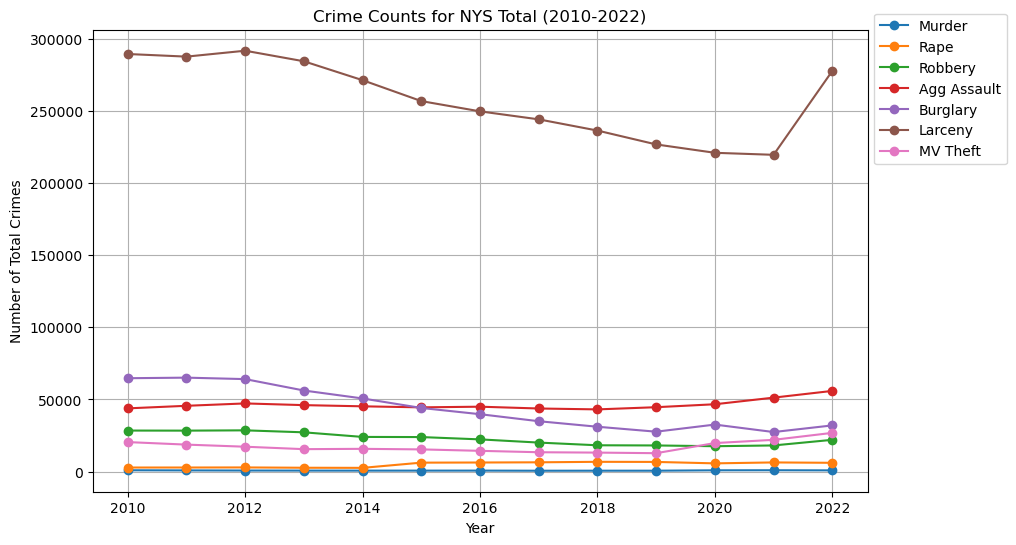

In [14]:
# showing the graph for different crime types over the full period

ax = crime_counts.plot(kind='line', marker='o', figsize=(10, 6))
plt.title('Crime Counts for NYS Total (2010-2022)')
plt.xlabel('Year')
plt.ylabel('Number of Total Crimes')
plt.grid(True)

handles, labels = ax.get_legend_handles_labels()
labels = [label.replace(' Count', '') for label in labels]

ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.0, 1.05))
plt.show()

In [15]:
# defining financial and non-financial crimes
nys_total_data['Financial Crimes'] = (
    nys_total_data['Larceny Count'] +
    nys_total_data['MV Theft Count'] +
    nys_total_data['Burglary Count'] +
    nys_total_data['Robbery Count']
)

C:\Users\mdlar\AppData\Local\Temp\ipykernel_19976\386505383.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nys_total_data['Financial Crimes'] = (


In [16]:
nys_total_data['Non-Financial Crimes'] = (
    nys_total_data['Murder Count'] +
    nys_total_data['Rape Count'] +
    nys_total_data['Agg Assault Count']
)

C:\Users\mdlar\AppData\Local\Temp\ipykernel_19976\2323577628.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nys_total_data['Non-Financial Crimes'] = (


In [17]:
crime_counts = nys_total_data[['Year', 'Financial Crimes', 'Non-Financial Crimes']]
crime_counts['Total'] = crime_counts['Financial Crimes'] + crime_counts['Non-Financial Crimes']
crime_counts.set_index('Year', inplace=True)

C:\Users\mdlar\AppData\Local\Temp\ipykernel_19976\1499144580.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crime_counts['Total'] = crime_counts['Financial Crimes'] + crime_counts['Non-Financial Crimes']


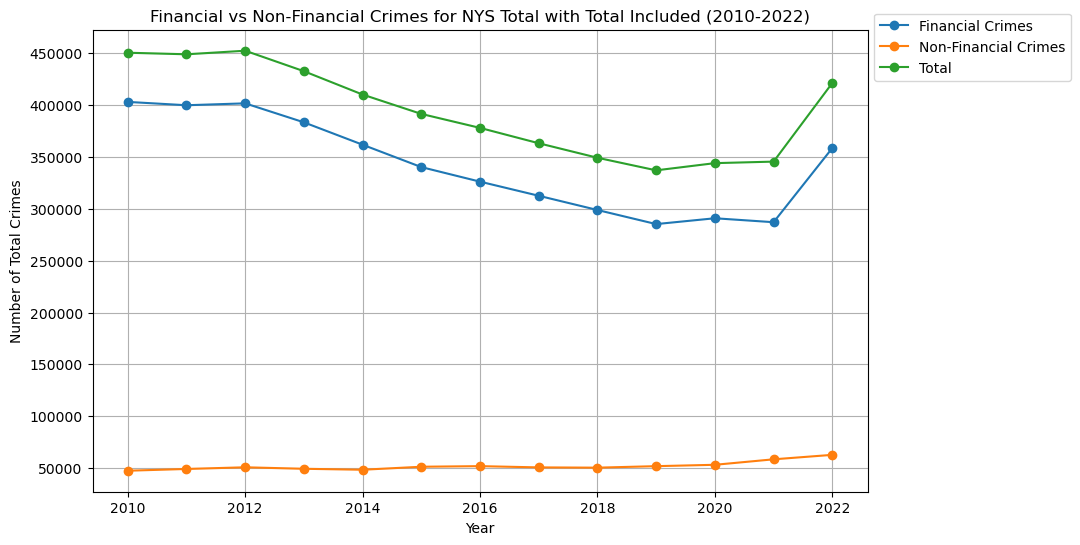

In [18]:
# visualizing total crime data 

crime_counts.plot(kind='line', marker='o', figsize=(10, 6))
plt.title('Financial vs Non-Financial Crimes for NYS Total with Total Included (2010-2022)')
plt.xlabel('Year')
plt.ylabel('Number of Total Crimes')
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.05))
plt.show()

In [19]:
# unemployment_df
# house_income_df
# nys_total_data

# this enters the repeated process of generating r squared values through linear
# regression and generating the associated scatter plot

In [20]:
nys_total_data = nys_total_data[nys_total_data['Year'] >= 2000]
unemployment_df = unemployment_df[unemployment_df['Year'] >= 2000]

X = nys_total_data['Financial Crimes']
y = unemployment_df['Rate']

In [21]:
X = sm.add_constant(X)

In [22]:
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

In [23]:
print(y.shape)
print(X.shape)

model = sm.OLS(y, X).fit()

print(X['Financial Crimes'].head())

(13,)
(13, 2)
0    403099
1    399878
2    401708
3    383402
4    361810
Name: Financial Crimes, dtype: int64


                            OLS Regression Results                            
Dep. Variable:                   Rate   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     2.963
Date:                Fri, 15 Dec 2023   Prob (F-statistic):              0.113
Time:                        19:56:53   Log-Likelihood:                -25.717
No. Observations:                  13   AIC:                             55.43
Df Residuals:                      11   BIC:                             56.56
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.6838      4.163  

C:\Users\mdlar\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


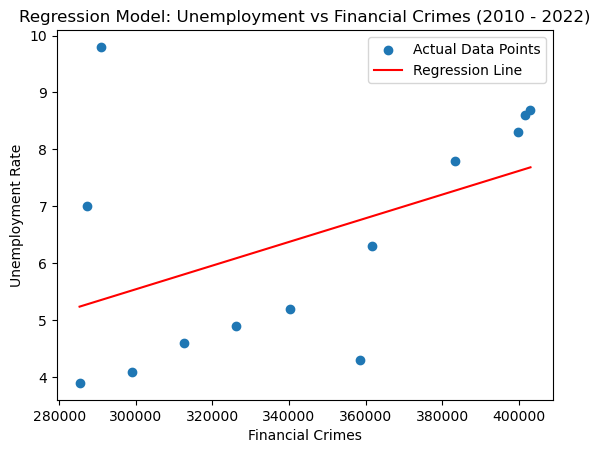

In [24]:
print(model.summary())
UF = model.rsquared

x_values = X['Financial Crimes'].values
y_values = y.values

sorted_indices = np.argsort(x_values)
x_values_sorted = x_values[sorted_indices]
y_values_sorted = y_values[sorted_indices]

plt.scatter(x_values_sorted, y_values_sorted, label='Actual Data Points')

plt.plot(x_values_sorted, model.predict(X.loc[sorted_indices]), color='red', label='Regression Line')

plt.xlabel('Financial Crimes')
plt.ylabel('Unemployment Rate')
plt.title('Regression Model: Unemployment vs Financial Crimes (2010 - 2022)')

plt.legend()

plt.show()


In [25]:
X = nys_total_data['Non-Financial Crimes']
X = sm.add_constant(X)

In [26]:
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

In [27]:
model = sm.OLS(y, X).fit()
print(X.columns)

Index(['const', 'Non-Financial Crimes'], dtype='object')


                            OLS Regression Results                            
Dep. Variable:                   Rate   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.9421
Date:                Fri, 15 Dec 2023   Prob (F-statistic):              0.353
Time:                        19:56:55   Log-Likelihood:                -26.733
No. Observations:                  13   AIC:                             57.47
Df Residuals:                      11   BIC:                             58.60
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   13.5092 

C:\Users\mdlar\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


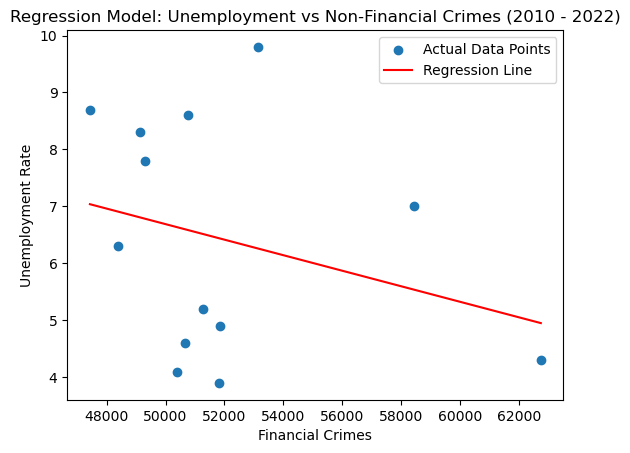

In [28]:
print(model.summary())
UNF = model.rsquared

x_values = X['Non-Financial Crimes'].values
y_values = y.values

sorted_indices = np.argsort(x_values)
x_values_sorted = x_values[sorted_indices]
y_values_sorted = y_values[sorted_indices]

plt.scatter(x_values_sorted, y_values_sorted, label='Actual Data Points')

plt.plot(x_values_sorted, model.predict(X.loc[sorted_indices]), color='red', label='Regression Line')

plt.xlabel('Financial Crimes')
plt.ylabel('Unemployment Rate')
plt.title('Regression Model: Unemployment vs Non-Financial Crimes (2010 - 2022)')

plt.legend()

plt.show()

In [29]:
X = nys_total_data['Financial Crimes']
y = house_income_df['Yearly Income']

In [30]:
X = sm.add_constant(X)

In [31]:
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

In [32]:
model = sm.OLS(y, X).fit()

print(y.shape)

(13,)


                            OLS Regression Results                            
Dep. Variable:          Yearly Income   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                     20.54
Date:                Fri, 15 Dec 2023   Prob (F-statistic):           0.000855
Time:                        19:56:57   Log-Likelihood:                -130.23
No. Observations:                  13   AIC:                             264.5
Df Residuals:                      11   BIC:                             265.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.191e+05   1.29e+04  

C:\Users\mdlar\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


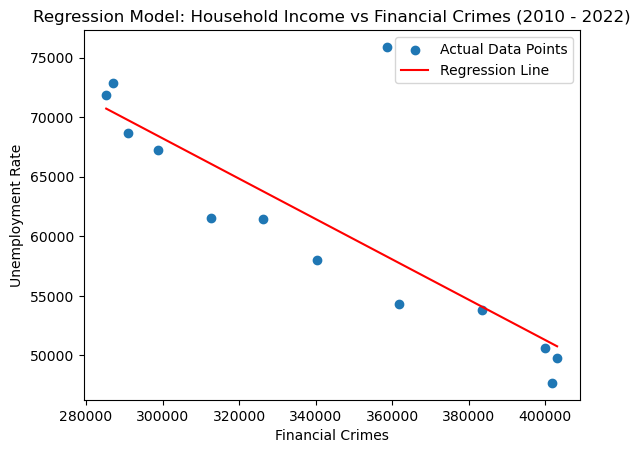

In [33]:
print(model.summary())
IF = model.rsquared

x_values = X['Financial Crimes'].values
y_values = y.values

sorted_indices = np.argsort(x_values)
x_values_sorted = x_values[sorted_indices]
y_values_sorted = y_values[sorted_indices]

plt.scatter(x_values_sorted, y_values_sorted, label='Actual Data Points')

plt.plot(x_values_sorted, model.predict(X.loc[sorted_indices]), color='red', label='Regression Line')

plt.xlabel('Financial Crimes')
plt.ylabel('Unemployment Rate')
plt.title('Regression Model: Household Income vs Financial Crimes (2010 - 2022)')

plt.legend()

plt.show()

In [34]:
X = nys_total_data['Non-Financial Crimes']

In [35]:
X = sm.add_constant(X)

In [36]:
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

In [37]:
model = sm.OLS(y, X).fit()

C:\Users\mdlar\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                            OLS Regression Results                            
Dep. Variable:          Yearly Income   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     16.72
Date:                Fri, 15 Dec 2023   Prob (F-statistic):            0.00179
Time:                        19:56:59   Log-Likelihood:                -131.07
No. Observations:                  13   AIC:                             266.1
Df Residuals:                      11   BIC:                             267.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -3.022e+04 

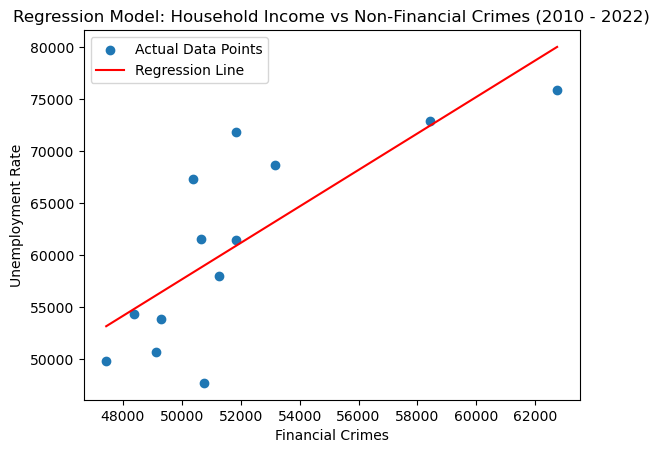

In [38]:
print(model.summary())
INF = model.rsquared

x_values = X['Non-Financial Crimes'].values
y_values = y.values

sorted_indices = np.argsort(x_values)
x_values_sorted = x_values[sorted_indices]
y_values_sorted = y_values[sorted_indices]

plt.scatter(x_values_sorted, y_values_sorted, label='Actual Data Points')

plt.plot(x_values_sorted, model.predict(X.loc[sorted_indices]), color='red', label='Regression Line')

plt.xlabel('Financial Crimes')
plt.ylabel('Unemployment Rate')
plt.title('Regression Model: Household Income vs Non-Financial Crimes (2010 - 2022)')

plt.legend()

plt.show()

In [39]:
rsquared_matrix = [[UF, UNF], [IF, INF]]
rsquared_df = pd.DataFrame(rsquared_matrix, columns=['Financial Crimes', 'Non-Financial Crimes'], index=['Unemployment', 'Household Income'])

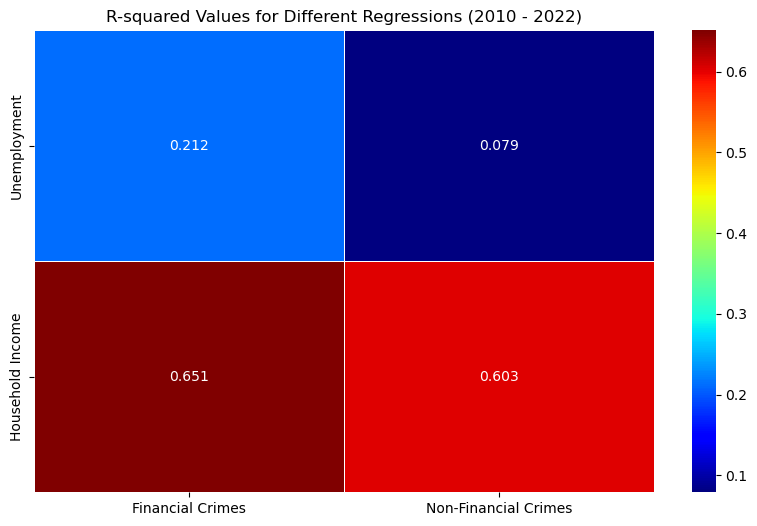

In [40]:
plt.figure(figsize=(10, 6))
sns.heatmap(rsquared_df, annot=True, cmap="jet", cbar=True, fmt=".3f", linewidths=.5)
plt.title("R-squared Values for Different Regressions (2010 - 2022)")
plt.show()

                            OLS Regression Results                            
Dep. Variable:                   Rate   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     331.8
Date:                Fri, 15 Dec 2023   Prob (F-statistic):           3.72e-07
Time:                        19:57:01   Log-Likelihood:               -0.39442
No. Observations:                   9   AIC:                             4.789
Df Residuals:                       7   BIC:                             5.183
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -9.7724      0.898  

C:\Users\mdlar\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


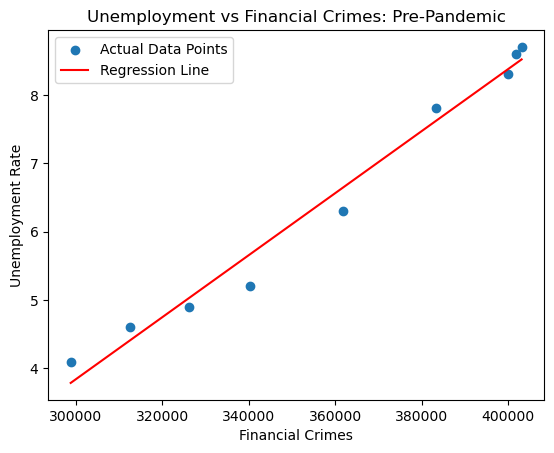

In [41]:
# Pre-Pandemic: 2010 - 2018
# Financial Crimes vs Unemployment
crime_df_pre = nys_total_data[(nys_total_data['Year'] >= 2010) & (nys_total_data['Year'] <= 2018)]
unemployment_pre = unemployment_df[(unemployment_df['Year'] >= 2010) & (unemployment_df['Year'] <= 2018)]

X = crime_df_pre['Financial Crimes']
y = unemployment_pre['Rate']

X = sm.add_constant(X)

X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

model = sm.OLS(y, X).fit()

print(model.summary())
UF = model.rsquared

x_values = X['Financial Crimes'].values
y_values = y.values

sorted_indices = np.argsort(x_values)
x_values_sorted = x_values[sorted_indices]
y_values_sorted = y_values[sorted_indices]

plt.scatter(x_values_sorted, y_values_sorted, label='Actual Data Points')

plt.plot(x_values_sorted, model.predict(X.loc[sorted_indices]), color='red', label='Regression Line')

plt.xlabel('Financial Crimes')
plt.ylabel('Unemployment Rate')
plt.title('Unemployment vs Financial Crimes: Pre-Pandemic')

plt.legend()

plt.show()

                            OLS Regression Results                            
Dep. Variable:                   Rate   R-squared:                       0.366
Model:                            OLS   Adj. R-squared:                  0.276
Method:                 Least Squares   F-statistic:                     4.046
Date:                Fri, 15 Dec 2023   Prob (F-statistic):             0.0842
Time:                        19:57:02   Log-Likelihood:                -15.799
No. Observations:                   9   AIC:                             35.60
Df Residuals:                       7   BIC:                             35.99
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   45.6884 

C:\Users\mdlar\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


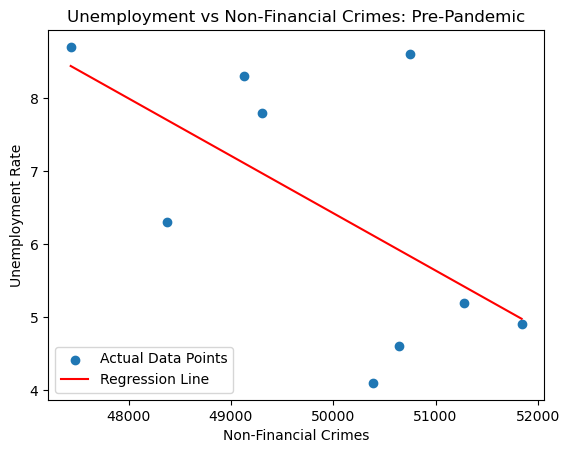

In [42]:
# Pre-Pandemic: 2010 - 2018
# Non-Financial Crimes vs. Unemployment
crime_df_pre = nys_total_data[(nys_total_data['Year'] >= 2010) & (nys_total_data['Year'] <= 2018)]
unemployment_pre = unemployment_df[(unemployment_df['Year'] >= 2010) & (unemployment_df['Year'] <= 2018)]

X = crime_df_pre['Non-Financial Crimes']
y = unemployment_pre['Rate']

X = sm.add_constant(X)

X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

model = sm.OLS(y, X).fit()

print(model.summary())
UNF = model.rsquared

x_values = X['Non-Financial Crimes'].values
y_values = y.values

sorted_indices = np.argsort(x_values)
x_values_sorted = x_values[sorted_indices]
y_values_sorted = y_values[sorted_indices]

plt.scatter(x_values_sorted, y_values_sorted, label='Actual Data Points')

plt.plot(x_values_sorted, model.predict(X.loc[sorted_indices]), color='red', label='Regression Line')

plt.xlabel('Non-Financial Crimes')
plt.ylabel('Unemployment Rate')
plt.title('Unemployment vs Non-Financial Crimes: Pre-Pandemic')

plt.legend()

plt.show()

                            OLS Regression Results                            
Dep. Variable:          Yearly Income   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     140.7
Date:                Fri, 15 Dec 2023   Prob (F-statistic):           6.88e-06
Time:                        19:57:02   Log-Likelihood:                -77.503
No. Observations:                   9   AIC:                             159.0
Df Residuals:                       7   BIC:                             159.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.118e+05   4724.351  

C:\Users\mdlar\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


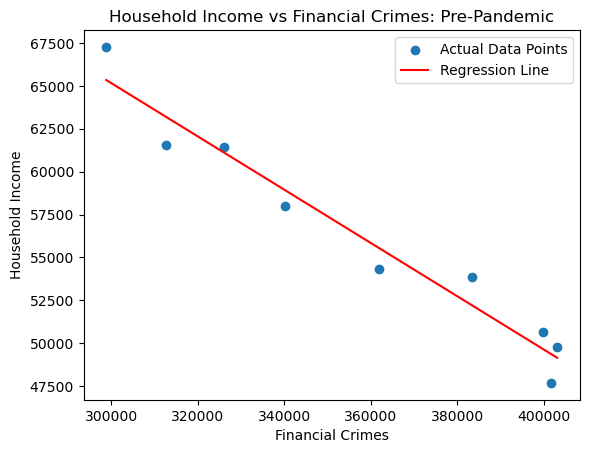

In [43]:
# Pre-Pandemic: 2010 - 2018
# Financial vs. Household Income
crime_df_pre = nys_total_data[(nys_total_data['Year'] >= 2010) & (nys_total_data['Year'] <= 2018)]
income_pre = house_income_df[(house_income_df['Year'] >= 2010) & (house_income_df['Year'] <= 2018)]

X = crime_df_pre['Financial Crimes']
y = income_pre['Yearly Income']

X = sm.add_constant(X)

X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

model = sm.OLS(y, X).fit()

print(model.summary())
IF = model.rsquared

x_values = X['Financial Crimes'].values
y_values = y.values

sorted_indices = np.argsort(x_values)
x_values_sorted = x_values[sorted_indices]
y_values_sorted = y_values[sorted_indices]

plt.scatter(x_values_sorted, y_values_sorted, label='Actual Data Points')

plt.plot(x_values_sorted, model.predict(X.loc[sorted_indices]), color='red', label='Regression Line')

plt.xlabel('Financial Crimes')
plt.ylabel('Household Income')
plt.title('Household Income vs Financial Crimes: Pre-Pandemic')

plt.legend()

plt.show()

C:\Users\mdlar\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                            OLS Regression Results                            
Dep. Variable:          Yearly Income   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     2.685
Date:                Fri, 15 Dec 2023   Prob (F-statistic):              0.145
Time:                        19:57:03   Log-Likelihood:                -89.763
No. Observations:                   9   AIC:                             183.5
Df Residuals:                       7   BIC:                             183.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -6.232e+04 

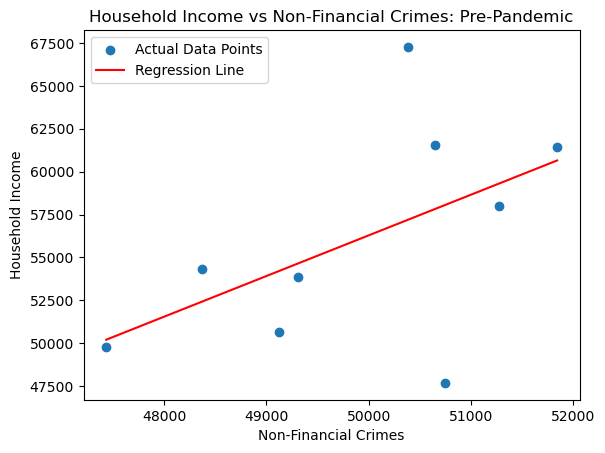

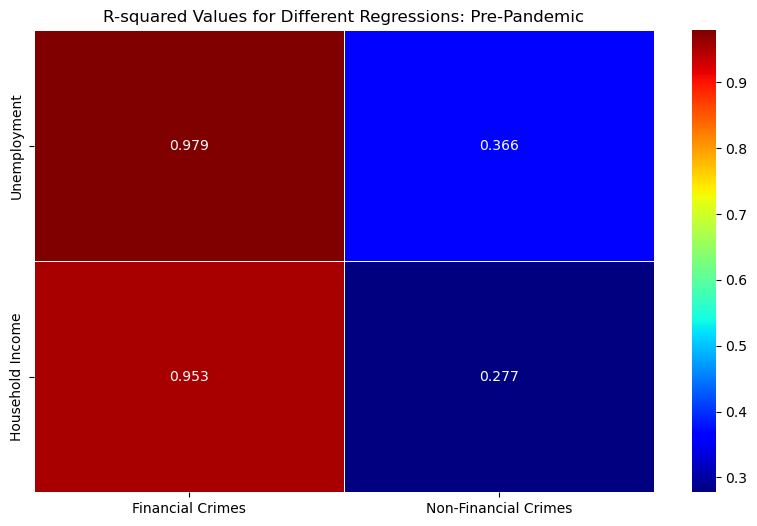

In [44]:
# Pre-Pandemic: 2010 - 2018
# Non-Financial vs. Household Income
crime_df_pre = nys_total_data[(nys_total_data['Year'] >= 2010) & (nys_total_data['Year'] <= 2018)]
income_pre = house_income_df[(house_income_df['Year'] >= 2010) & (house_income_df['Year'] <= 2018)]

X = crime_df_pre['Non-Financial Crimes']
y = income_pre['Yearly Income']

X = sm.add_constant(X)

X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

model = sm.OLS(y, X).fit()

print(model.summary())
INF = model.rsquared

x_values = X['Non-Financial Crimes'].values
y_values = y.values

sorted_indices = np.argsort(x_values)
x_values_sorted = x_values[sorted_indices]
y_values_sorted = y_values[sorted_indices]

plt.scatter(x_values_sorted, y_values_sorted, label='Actual Data Points')

plt.plot(x_values_sorted, model.predict(X.loc[sorted_indices]), color='red', label='Regression Line')

plt.xlabel('Non-Financial Crimes')
plt.ylabel('Household Income')
plt.title('Household Income vs Non-Financial Crimes: Pre-Pandemic')

plt.legend()

plt.show()

rsquared_matrix = [[UF, UNF], [IF, INF]]
rsquared_df = pd.DataFrame(rsquared_matrix, columns=['Financial Crimes', 'Non-Financial Crimes'], index=['Unemployment', 'Household Income'])

plt.figure(figsize=(10, 6))
sns.heatmap(rsquared_df, annot=True, cmap="jet", cbar=True, fmt=".3f", linewidths=.5)
plt.title("R-squared Values for Different Regressions: Pre-Pandemic")
plt.show()

C:\Users\mdlar\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


                            OLS Regression Results                            
Dep. Variable:                   Rate   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                 -0.239
Method:                 Least Squares   F-statistic:                    0.4215
Date:                Fri, 15 Dec 2023   Prob (F-statistic):              0.583
Time:                        19:57:03   Log-Likelihood:                -8.7468
No. Observations:                   4   AIC:                             21.49
Df Residuals:                       2   BIC:                             20.27
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               16.0809     15.219  

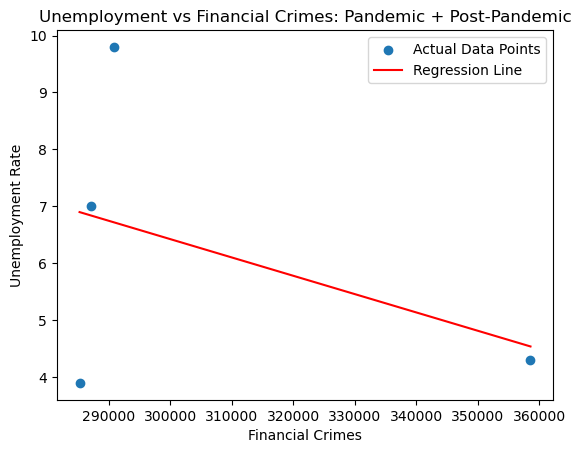

In [45]:
# Pandemic/Post-pandemic: 2019 - 2022
# Financial Crimes vs Unemployment
crime_df_pre = nys_total_data[(nys_total_data['Year'] >= 2019) & (nys_total_data['Year'] <= 2022)]
unemployment_pre = unemployment_df[(unemployment_df['Year'] >= 2019) & (unemployment_df['Year'] <= 2022)]

X = crime_df_pre['Financial Crimes']
y = unemployment_pre['Rate']

X = sm.add_constant(X)

X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

model = sm.OLS(y, X).fit()

print(model.summary())
UF = model.rsquared

x_values = X['Financial Crimes'].values
y_values = y.values

sorted_indices = np.argsort(x_values)
x_values_sorted = x_values[sorted_indices]
y_values_sorted = y_values[sorted_indices]

plt.scatter(x_values_sorted, y_values_sorted, label='Actual Data Points')

plt.plot(x_values_sorted, model.predict(X.loc[sorted_indices]), color='red', label='Regression Line')

plt.xlabel('Financial Crimes')
plt.ylabel('Unemployment Rate')
plt.title('Unemployment vs Financial Crimes: Pandemic + Post-Pandemic')

plt.legend()

plt.show()


C:\Users\mdlar\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


                            OLS Regression Results                            
Dep. Variable:                   Rate   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                 -0.381
Method:                 Least Squares   F-statistic:                    0.1725
Date:                Fri, 15 Dec 2023   Prob (F-statistic):              0.718
Time:                        19:57:04   Log-Likelihood:                -8.9638
No. Observations:                   4   AIC:                             21.93
Df Residuals:                       2   BIC:                             20.70
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   14.9341 

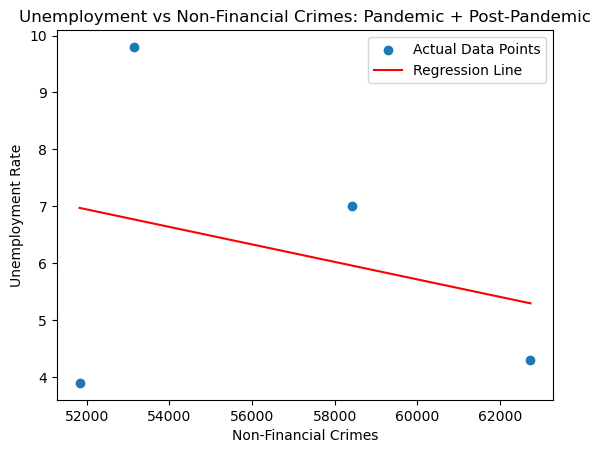

In [46]:
# Pandemic/Post-pandemic: 2019 - 2022
# Non-Financial Crimes vs Unemployment
crime_df_pre = nys_total_data[(nys_total_data['Year'] >= 2019) & (nys_total_data['Year'] <= 2022)]
unemployment_pre = unemployment_df[(unemployment_df['Year'] >= 2019) & (unemployment_df['Year'] <= 2022)]

X = crime_df_pre['Non-Financial Crimes']
y = unemployment_pre['Rate']

X = sm.add_constant(X)

X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

model = sm.OLS(y, X).fit()

print(model.summary())
UNF = model.rsquared

x_values = X['Non-Financial Crimes'].values
y_values = y.values

sorted_indices = np.argsort(x_values)
x_values_sorted = x_values[sorted_indices]
y_values_sorted = y_values[sorted_indices]

plt.scatter(x_values_sorted, y_values_sorted, label='Actual Data Points')

plt.plot(x_values_sorted, model.predict(X.loc[sorted_indices]), color='red', label='Regression Line')

plt.xlabel('Non-Financial Crimes')
plt.ylabel('Unemployment Rate')
plt.title('Unemployment vs Non-Financial Crimes: Pandemic + Post-Pandemic')

plt.legend()

plt.show()

C:\Users\mdlar\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


                            OLS Regression Results                            
Dep. Variable:          Yearly Income   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.368
Method:                 Least Squares   F-statistic:                     2.747
Date:                Fri, 15 Dec 2023   Prob (F-statistic):              0.239
Time:                        19:57:04   Log-Likelihood:                -35.387
No. Observations:                   4   AIC:                             74.77
Df Residuals:                       2   BIC:                             73.55
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             5.274e+04   1.19e+04  

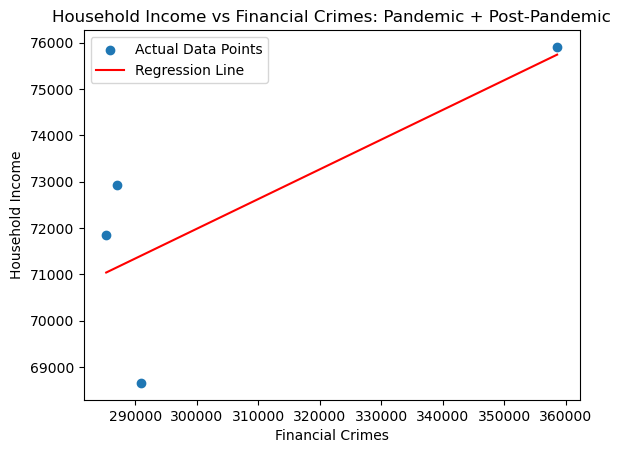

In [47]:
# Pandemic/Post-Pandemic: 2019 - 2022
# Financial vs. Household Income
crime_df_pre = nys_total_data[(nys_total_data['Year'] >= 2019) & (nys_total_data['Year'] <= 2022)]
income_pre = house_income_df[(house_income_df['Year'] >= 2019) & (house_income_df['Year'] <= 2022)]

X = crime_df_pre['Financial Crimes']
y = income_pre['Yearly Income']

X = sm.add_constant(X)

X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

model = sm.OLS(y, X).fit()

print(model.summary())
IF = model.rsquared

x_values = X['Financial Crimes'].values
y_values = y.values

sorted_indices = np.argsort(x_values)
x_values_sorted = x_values[sorted_indices]
y_values_sorted = y_values[sorted_indices]

plt.scatter(x_values_sorted, y_values_sorted, label='Actual Data Points')

plt.plot(x_values_sorted, model.predict(X.loc[sorted_indices]), color='red', label='Regression Line')

plt.xlabel('Financial Crimes')
plt.ylabel('Household Income')
plt.title('Household Income vs Financial Crimes: Pandemic + Post-Pandemic')

plt.legend()

plt.show()

C:\Users\mdlar\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


                            OLS Regression Results                            
Dep. Variable:          Yearly Income   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                     4.888
Date:                Fri, 15 Dec 2023   Prob (F-statistic):              0.158
Time:                        19:57:05   Log-Likelihood:                -34.643
No. Observations:                   4   AIC:                             73.29
Df Residuals:                       2   BIC:                             72.06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 4.396e+04 

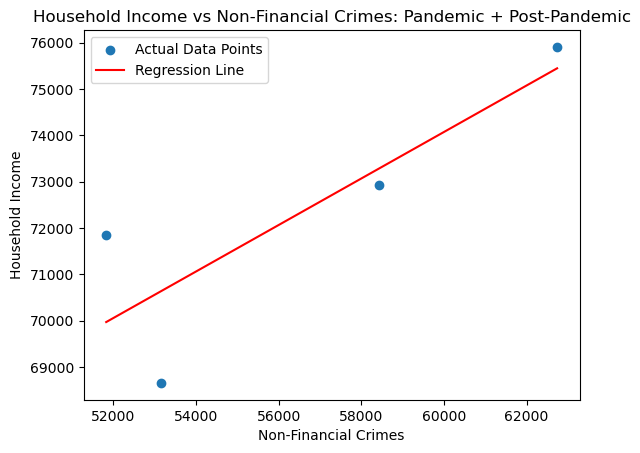

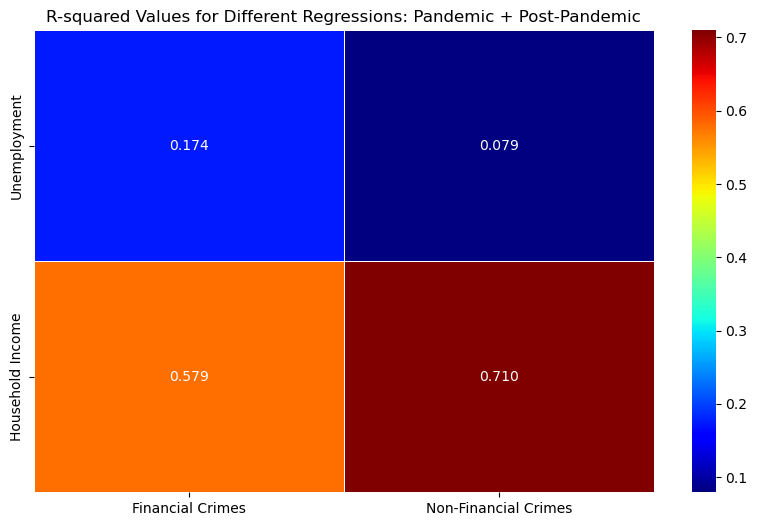

In [48]:
# Pandemic/Post-Pandemic: 2019 - 2022
# Non-Financial vs. Household Income
crime_df_pre = nys_total_data[(nys_total_data['Year'] >= 2019) & (nys_total_data['Year'] <= 2022)]
income_pre = house_income_df[(house_income_df['Year'] >= 2019) & (house_income_df['Year'] <= 2022)]

X = crime_df_pre['Non-Financial Crimes']
y = income_pre['Yearly Income']

X = sm.add_constant(X)

X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

model = sm.OLS(y, X).fit()

print(model.summary())
INF = model.rsquared

x_values = X['Non-Financial Crimes'].values
y_values = y.values

sorted_indices = np.argsort(x_values)
x_values_sorted = x_values[sorted_indices]
y_values_sorted = y_values[sorted_indices]

plt.scatter(x_values_sorted, y_values_sorted, label='Actual Data Points')

plt.plot(x_values_sorted, model.predict(X.loc[sorted_indices]), color='red', label='Regression Line')

plt.xlabel('Non-Financial Crimes')
plt.ylabel('Household Income')
plt.title('Household Income vs Non-Financial Crimes: Pandemic + Post-Pandemic')

plt.legend()

plt.show()

rsquared_matrix = [[UF, UNF], [IF, INF]]
rsquared_df = pd.DataFrame(rsquared_matrix, columns=['Financial Crimes', 'Non-Financial Crimes'], index=['Unemployment', 'Household Income'])

plt.figure(figsize=(10, 6))
sns.heatmap(rsquared_df, annot=True, cmap="jet", cbar=True, fmt=".3f", linewidths=.5)
plt.title("R-squared Values for Different Regressions: Pandemic + Post-Pandemic")
plt.show()

In [50]:
import pandas as pd 
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

In [51]:
#Parsing Crime per year from online dataset 
df = pd.read_csv("Crime_per_month_NY.csv")
df['Index Total'] = pd.to_numeric(df['Index Total'].str.replace(',', ''), errors='coerce')

selected_columns = ["County", "Agency", "Year", "Index Total"]

# Creating a new dataset with only the selected columns
new_dataset = df[selected_columns]
crime_per_year_df = new_dataset[new_dataset['Agency'] == 'County Total']
crime_per_year_df = crime_per_year_df.groupby('Year')['Index Total'].mean().round().astype(int).reset_index()
# crime_per_year_df.to_csv("crime_per_year_df")

#Getting the dataset of Income Per year
median_income= pd.read_csv("median_income.csv")

#Getting the unemployement dataset per month 
unemployment = pd.read_csv("unemployement.csv")

sc = ['Year','Month','Unemployement_rate ']
unemployment = unemployment[sc]

#merging income and crime index
income_crime = pd.merge(crime_per_year_df, median_income, on="Year", how="inner")

in_crime = income_crime.copy(deep=True)
in_crime = in_crime[in_crime['Year'] >= 2010]

# Converting 'Year' and 'Month' to datetime format
income_crime['Year'] = pd.to_datetime(income_crime['Year'], format='%Y')
unemployment['Month'] = pd.to_datetime(unemployment['Month'], format='%Y %b')

# Filtering data starting from the year 2010
income_crime = income_crime[income_crime['Year'] >= '2010']
unemployment = unemployment[unemployment['Month'].dt.year >= 2010]

# Removing commas and convert 'Income' to numeric
income_crime['Income'] = income_crime['Income'].replace(',', '', regex=True).astype(float)
# display(unemployment)
in_crime = pd.merge(in_crime, unemployment, on='Year', how='left')
in_crime['Income'] = in_crime['Income'].replace(',', '', regex=True).astype(float)

in_crime = in_crime[in_crime.index % 12 == 0].reset_index()
# display(in_crime)

In [52]:
# parsing the data sets by financial and non financial 

financial = pd.DataFrame()
nonfinancial = pd.DataFrame()
financial[['year','larceny', 'mv theft', 'burglary', 'robbery'] ]= df[['Year', 'Larceny', 'Motor Vehicle Theft', 'Burglary', 'Robbery']]
nonfinancial[['year','murder', 'rape', 'agg assault']]= df[['Year','Murder', 'Rape', 'Aggravated Assault']]
financial = financial[financial['year'] >= 2010]
nonfinancial = nonfinancial[nonfinancial['year'] >= 2010]
financial[['larceny', 'mv theft', 'burglary', 'robbery']] = financial[['larceny', 'mv theft', 'burglary', 'robbery']].replace(',', '', regex=True).astype(float)
nonfinancial[['year','murder', 'rape', 'agg assault']]= nonfinancial[['year','murder', 'rape', 'agg assault']].replace(',', '', regex=True).astype(float)
financial = financial.groupby('year').sum().reset_index()
nonfinancial = nonfinancial.groupby('year').sum().reset_index()
finavg = financial.iloc[:, 1:].sum(axis=1)
financial['financial_sum'] = finavg
nonfavg = nonfinancial.iloc[:, 1:].sum(axis=1)
nonfinancial['nonfinancial_sum'] = nonfavg

in_crime = pd.concat([in_crime, financial['financial_sum']], axis=1)
in_crime = pd.concat([in_crime, nonfinancial['nonfinancial_sum']], axis=1)

display(in_crime)

,index,Year,Index Total,Income,Month,Unemployement_rate,financial_sum,nonfinancial_sum
0,0,2010,7267,49781.0,2010-01-01,9.0,646975.0,65987.0
1,12,2011,7242,50636.0,2011-01-01,8.4,639526.0,66814.0
2,24,2012,7298,47680.0,2012-01-01,8.6,640455.0,68702.0
3,36,2013,6979,53843.0,2013-01-01,8.3,605663.0,65394.0
4,48,2014,6616,54310.0,2014-01-01,7.0,571292.0,63883.0
5,60,2015,6315,58005.0,2015-01-01,5.7,533654.0,69408.0
6,72,2016,6097,61437.0,2016-01-01,4.8,511552.0,70102.0
7,84,2017,5858,61543.0,2017-01-01,4.7,486350.0,68854.0
8,96,2018,5633,67274.0,2018-01-01,4.5,456687.0,67619.0
9,108,2019,5437,71855.0,2019-01-01,4.0,434847.0,69229.0


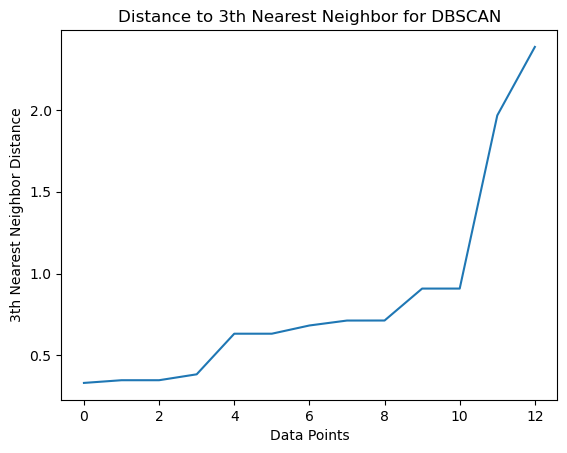

In [53]:
# determining parameters for DBSCAN based on data
features = ['Unemployement_rate ', 'Index Total', 'Income']
X = in_crime[features]

# standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# calc the distance
k = 3  
nbrs = NearestNeighbors(n_neighbors=k).fit(X_scaled)
distances, _ = nbrs.kneighbors(X_scaled)

# sorting distances to plot
distances = np.sort(distances[:, -1], axis=0)

plt.plot(distances)
plt.xlabel('Data Points')
plt.ylabel(f'{k}th Nearest Neighbor Distance')
plt.title(f'Distance to {k}th Nearest Neighbor for DBSCAN')
plt.show()

In [54]:
# loop to determine epsilon and minPts
# first used the loop to test multiple epsilon with minPts = 1
# then repurposed the loop to test multiple minPts with the most ideal epsilon

features = ['Index Total', 'Unemployement_rate ', 'Income']
X = in_crime[features]

scaler = StandardScaler()
X = scaler.fit_transform(X)

performances = pd.DataFrame()
i = 1
while i <= 3:
    dbscan = DBSCAN(eps=.9, min_samples=i)
    dbscan_labels = dbscan.fit_predict(X)
    print('TESTING MIN SAMPLES', i)

    # measuring the performance of the DBSCAN

    # silhouette score (similarity of object to cluster compared to others)
    # -1 to 1, high value means it is well matched to its own cluster 
    unique_labels = np.unique(dbscan_labels)
    print(dbscan_labels)

    if len(unique_labels) < 13:
        silhouette_avg = silhouette_score(in_crime[features], dbscan_labels)
        print(silhouette_avg)

        # ratio of the between-cluster variance to the within-cluster variance
        # higher score is better
        ch_score = calinski_harabasz_score(in_crime[features], dbscan_labels)
        print(ch_score)

        # average similarity between each cluster and its most similar cluster
        # lower score is better
        db_score = davies_bouldin_score(in_crime[features], dbscan_labels)
        print(db_score)
    else:
        print("NA\nNA\nNA\n")
    
    i += 1

# BASED ON THE ABOVE WILL TEST WITH .4, .5, AND .9 for epsilon

TESTING MIN SAMPLES 1
[0 0 0 0 0 1 1 1 1 1 1 2 3]
0.25712600454599677
16.32335705583931
0.49977393278108173
TESTING MIN SAMPLES 2
[ 0  0  0  0  0  1  1  1  1  1  1 -1 -1]
0.40845609051618503
26.252804644859957
0.5873335130032797
TESTING MIN SAMPLES 3
[ 0  0  0  0  0  1  1  1  1  1  1 -1 -1]
0.40845609051618503
26.252804644859957
0.5873335130032797


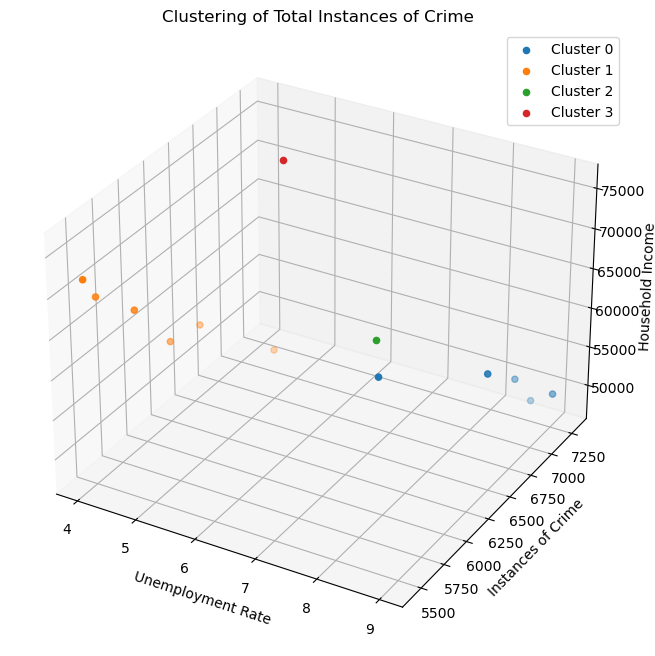

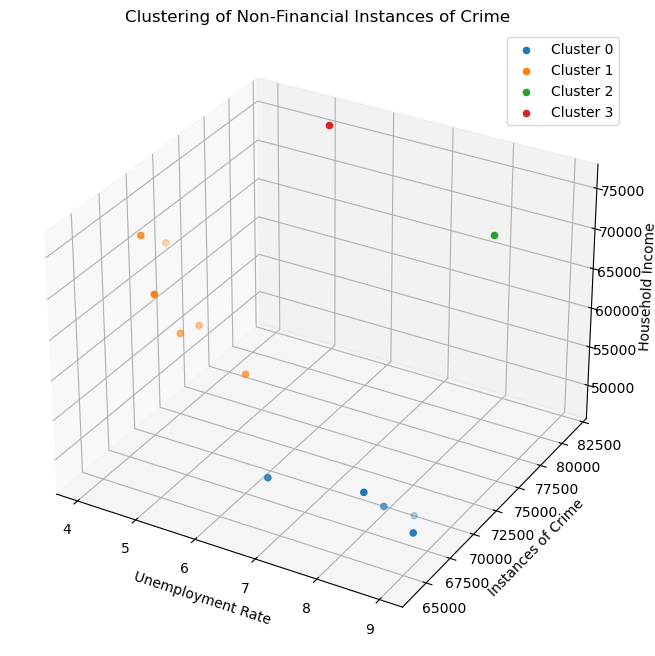

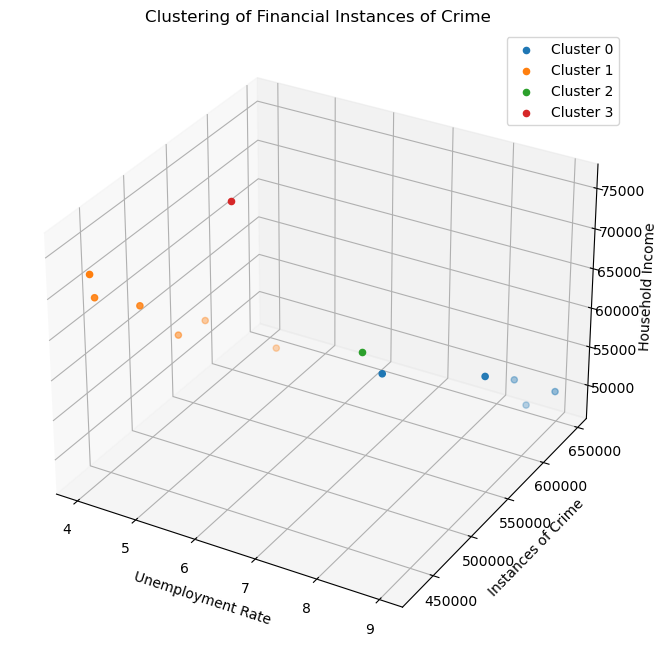

In [55]:
# START OF THE CLUSTERING CODE - DBSCAN 3D clustering plot

features = ['Unemployement_rate ', 'Index Total', 'Income']
X = in_crime[features]

scaler = StandardScaler()
X = scaler.fit_transform(X)

dbscan = DBSCAN(eps=.9, min_samples=1)
dbscan_labels = dbscan.fit_predict(X)

in_crime['Cluster'] = dbscan_labels

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# get marker labels based on the year 
for year in in_crime['Year']:
    if year < 2019:
        in_crime.loc[in_crime['Year'] == year, 'Style'] = 'o' 
    elif year < 2021:
        in_crime.loc[in_crime['Year'] == year, 'Style'] = 's'
    elif year >=2021:
        in_crime.loc[in_crime['Year'] == year, 'Style'] = '*'

for cluster_label in in_crime['Cluster'].unique():
    cluster_data = in_crime[in_crime['Cluster'] == cluster_label]
    ax.scatter(cluster_data['Unemployement_rate '], cluster_data['Index Total'], cluster_data['Income'], label=f'Cluster {cluster_label}')
    

ax.set_xlabel('Unemployment Rate')
ax.set_ylabel('Instances of Crime')
ax.set_zlabel('Household Income')

ax.legend()

plt.title('Clustering of Total Instances of Crime')
plt.show()




# CLUSTERING WITH NON FINANCIAL CRIME
features = ['Unemployement_rate ', 'nonfinancial_sum', 'Income']
X = in_crime[features]

scaler = StandardScaler()
X = scaler.fit_transform(X)

dbscan = DBSCAN(eps=.9, min_samples=1)
dbscan_labels = dbscan.fit_predict(X)

in_crime['Cluster_nf'] = dbscan_labels

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')


for cluster_label in in_crime['Cluster_nf'].unique():
    cluster_data = in_crime[in_crime['Cluster_nf'] == cluster_label]
    ax.scatter(cluster_data['Unemployement_rate '], cluster_data['nonfinancial_sum'], cluster_data['Income'], label=f'Cluster {cluster_label}')
    

ax.set_xlabel('Unemployment Rate')
ax.set_ylabel('Instances of Crime')
ax.set_zlabel('Household Income')

ax.legend()

plt.title('Clustering of Non-Financial Instances of Crime')
plt.show()




# CLUSTERING WITH FINANCIAL CRIME
features = ['Unemployement_rate ', 'financial_sum', 'Income']
X = in_crime[features]

scaler = StandardScaler()
X = scaler.fit_transform(X)

dbscan = DBSCAN(eps=.9, min_samples=1)
dbscan_labels = dbscan.fit_predict(X)

in_crime['Clusterf'] = dbscan_labels

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')


for cluster_label in in_crime['Clusterf'].unique():
    cluster_data = in_crime[in_crime['Clusterf'] == cluster_label]
    ax.scatter(cluster_data['Unemployement_rate '], cluster_data['financial_sum'], cluster_data['Income'], label=f'Cluster {cluster_label}')
    

ax.set_xlabel('Unemployment Rate')
ax.set_ylabel('Instances of Crime')
ax.set_zlabel('Household Income')

ax.legend()

plt.title('Clustering of Financial Instances of Crime')
plt.show()


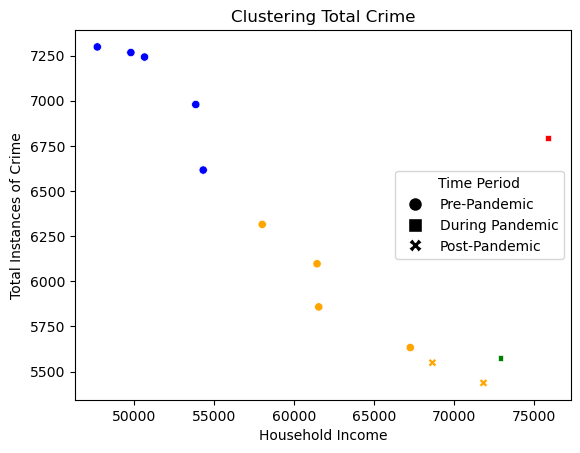

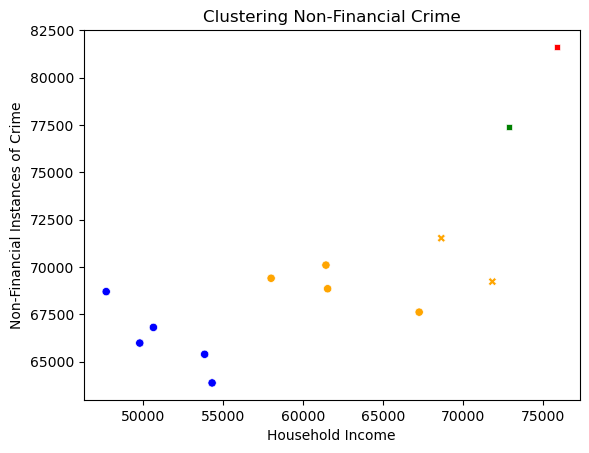

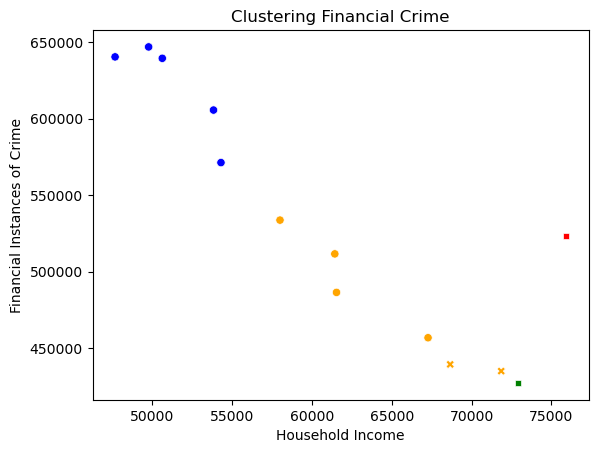

In [56]:
from matplotlib.lines import Line2D

# pick the color palette 
cluster_palette = {0: 'blue', 1: 'orange', 2: 'green', 3: 'red'}

# scatterplot for total crime
ax1 = sns.scatterplot(
    x='Income',
    y='Index Total',
    hue='Cluster',
    data=in_crime,
    legend='brief',
    palette=cluster_palette,
    style=in_crime['Style'].tolist()
)
ax1.set(xlabel='Household Income', ylabel='Total Instances of Crime')

# legend for the first figure
legend_handles_time = [
    Line2D([0], [0], marker='o', color='white', label='Pre-Pandemic', markerfacecolor='black', markersize=10),
    Line2D([0], [0], marker='s', color='white', label='During Pandemic', markerfacecolor='black', markersize=10),
    Line2D([0], [0], marker='X', color='white', label='Post-Pandemic', markerfacecolor='black', markersize=10)
]

plt.legend(handles=legend_handles_time, title='Time Period', loc='center right')
plt.title('Clustering Total Crime')
plt.show()

# second scatterplot for non financial crime
ax2 = sns.scatterplot(
    x='Income',
    y='nonfinancial_sum',
    hue='Cluster',
    data=in_crime,
    legend=False,
    palette=cluster_palette,
    style=in_crime['Style'].tolist()
)
ax2.set(xlabel='Household Income', ylabel='Non-Financial Instances of Crime')
plt.title('Clustering Non-Financial Crime')
plt.show()

# third scatterplot for non financial crime
ax3 = sns.scatterplot(
    x='Income',
    y='financial_sum',
    hue='Cluster',
    data=in_crime,
    legend=False,
    palette=cluster_palette,
    style=in_crime['Style'].tolist()
)
ax3.set(xlabel='Household Income', ylabel='Financial Instances of Crime')
plt.title('Clustering Financial Crime')
plt.show()


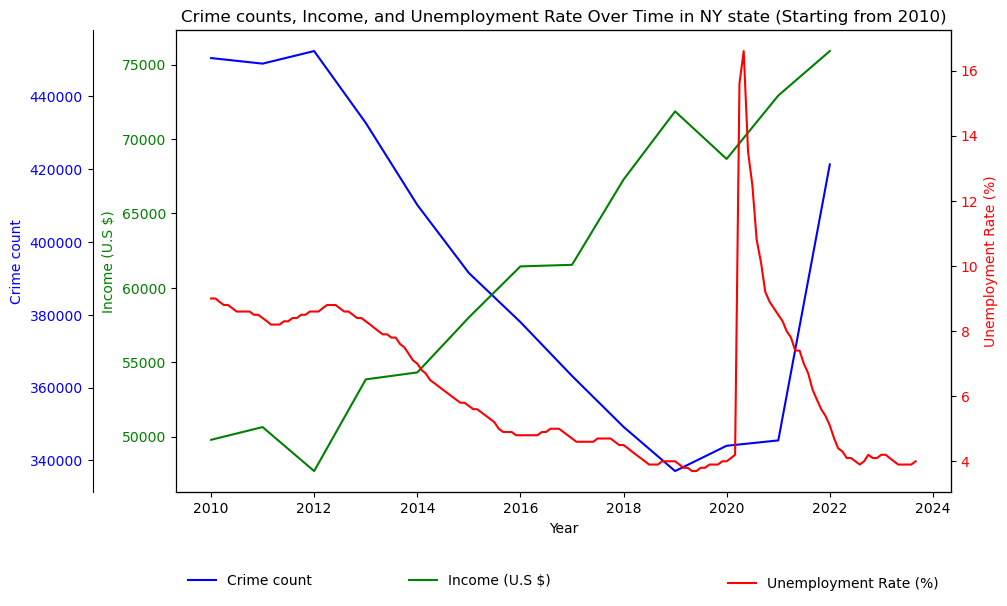

In [57]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt


#parsing Crime per year from online dataset 
crime_df = pd.read_csv("Crime_per_month_NY.csv")
crime_df['Index Total'] = pd.to_numeric(crime_df['Index Total'].str.replace(',', ''), errors='coerce')

selected_columns = ["County", "Agency", "Year", "Index Total"]

#creating a new dataset with only the selected columns which are our column of interest 
new_dataset = crime_df[selected_columns]

crime_per_year_df = new_dataset[new_dataset['Agency'] == 'County Total']
crime_per_year_df = crime_per_year_df.groupby('Year')['Index Total'].sum().round().astype(int).reset_index()

'''#display(crime_per_year_df)'''
crime_per_year_df.to_csv("crime_per_year_df.csv") #saving just in case 

#getting the dataset of Income Per year
median_income= pd.read_csv("median_income.csv")
# display(median_income)


#getting the unemployement dataset per month 
unemployment = pd.read_csv("unemployement.csv")

#columns of interest for unemployement dataset 
sc = ['Year','Month','Unemployement_rate ']

#selecting only our columns of interest from the unemployement dataset 
unemployment = unemployment[sc]
'''display(unemployment)'''

#merging income and crime index
income_crime = pd.merge(crime_per_year_df, median_income, on="Year", how="inner")

'''display(income_crime)'''


#converting 'Year' and 'Month' to datetime format
income_crime['Year'] = pd.to_datetime(income_crime['Year'], format='%Y')
unemployment['Month'] = pd.to_datetime(unemployment['Month'], format='%Y %b')

#filtering data starting from the year 2010
income_crime = income_crime[income_crime['Year'] >= '2010']
unemployment = unemployment[unemployment['Month'].dt.year >= 2010]

#removing commas and convert 'Income' to numeric
income_crime['Income'] = income_crime['Income'].replace(',', '', regex=True).astype(float)

#plotting of preliminary findings 
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting 'Index Total' on the left y-axis
ax1.plot(income_crime['Year'], income_crime['Index Total'], color='blue', label='Crime count')
ax1.set_xlabel('Year')
ax1.set_ylabel('Crime count', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

#creating a second y-axis for 'Income' on the left side
ax2 = ax1.twinx()
ax2.plot(income_crime['Year'], income_crime['Income'], color='green', label='Income (U.S $)')
ax2.set_ylabel('Income (U.S $)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

#moving 'Income' y-axis to the left
ax2.yaxis.tick_left()
ax2.yaxis.set_label_position("left")

#creating a third y-axis for 'Unemployment Rate'
ax3 = ax1.twinx()
ax3.plot(unemployment['Month'], unemployment['Unemployement_rate '], color='red', label='Unemployment Rate (%)')
ax3.set_ylabel('Unemployment Rate (%)', color='red')
ax3.tick_params(axis='y', labelcolor='red')

#title of our preliminary findings figure 
plt.title('Crime counts, Income, and Unemployment Rate Over Time in NY state (Starting from 2010)')

#moving axes 
ax1.spines['left'].set_position(('outward', 60))
ax2.spines['right'].set_position(('outward', 0))
ax3.spines['right'].set_position(('outward', 0))

#setting legends
ax1.legend(loc='upper left', bbox_to_anchor=(0, -0.15), frameon=False)
ax2.legend(loc='upper right', bbox_to_anchor=(0.5, -0.15), frameon=False)
ax3.legend(loc='lower right', bbox_to_anchor=(1, -0.24), frameon=False)
plt.show()



In [58]:
crime_df # to see the shape of our crime dataset 

,County,Agency,Year,Months Reported,Index Total,Violent Total,Murder,Rape,Robbery,Aggravated Assault,Property Total,Burglary,Larceny,Motor Vehicle Theft,Region
0,Albany,Albany City PD,2022,12.0,4746,944,14,70,233,627,"3,802",566,"2,670",566,Non-New York City
1,Albany,Albany County Park PD,2022,12.0,1,0,0,0,0,0,1,0,1,0,Non-New York City
2,Albany,Albany County Sheriff,2022,12.0,127,11,0,3,1,7,116,10,97,9,Non-New York City
3,Albany,Albany County State Police,2022,12.0,131,42,0,26,5,11,89,7,77,5,Non-New York City
4,Albany,Altamont Vg PD,2022,12.0,1,0,0,0,0,0,1,0,1,0,Non-New York City
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22043,Yates,County Total,1990,NaN,507,34,0,5,0,29,473,104,361,8,Non-New York City
22044,Yates,Penn Yan Vg PD,1990,NaN,142,3,0,1,0,2,139,11,123,5,Non-New York City
22045,Yates,Yates County Park PD,1990,NaN,1,0,0,0,0,0,1,0,1,0,Non-New York City
22046,Yates,Yates County Sheriff,1990,NaN,318,29,0,4,0,25,289,84,202,3,Non-New York City


In [59]:
#converting all numeric columns to numeric but county column 
crime_df = crime_df.apply(lambda col: pd.to_numeric(col, errors='coerce') if col.name != 'County' and col.name != 'Year'  else col)
#dropping columns that are useless for our purpose
crime_df.drop(["Months Reported", "Agency", "Region"], axis=1, inplace=True)
crime_df.groupby('Year').sum().reset_index()
#maiking crime dataset by county, thus grouping by county and year 
crime_per_county = crime_df.groupby(['County', "Year"]).sum().astype(int).reset_index()
crime_per_county = crime_per_county[crime_per_county['Year'] >= 2010]
# crime_per_county.head()


In [60]:
crime_per_county

,County,Year,Index Total,Violent Total,Murder,Rape,Robbery,Aggravated Assault,Property Total,Burglary,Larceny,Motor Vehicle Theft
20,Albany,2010,22074,1182,6,122,734,1502,2958,1594,2429,710
21,Albany,2011,21454,1166,14,94,792,1432,2759,1571,2237,502
22,Albany,2012,19948,1011,12,134,624,1252,2520,1502,2065,522
23,Albany,2013,18912,1005,18,94,586,1312,2376,1203,2002,500
24,Albany,2014,18372,1003,28,92,632,1254,2286,1129,1950,466
...,...,...,...,...,...,...,...,...,...,...,...,...
2041,Yates,2018,490,34,2,8,0,24,456,104,342,10
2042,Yates,2019,374,46,0,24,0,22,328,84,240,4
2043,Yates,2020,442,32,2,16,2,12,410,48,358,4
2044,Yates,2021,366,68,0,42,0,26,298,28,256,14


In [61]:
#Creating a new column indicating urban or rural
rural_counties = ['Allegany', 'Broome', 'Cattaraugus', 'Cayuga', 'Chautauqua', 'Chemung', 'Chenango',
                  'Clinton', 'Columbia', 'Cortland', 'Delaware', 'Essex', 'Franklin', 'Fulton',
                  'Genesee', 'Greene', 'Hamilton', 'Herkimer', 'Jefferson', 'Lewis', 'Livingston',
                  'Madison', 'Montgomery', 'Ontario', 'Orleans', 'Oswego', 'Otsego', 'Putnam',
                  'Rensselaer', 'Schenectady', 'Schoharie', 'Schuyler', 'Seneca', 'St. Lawrence',
                  'Steuben', 'Sullivan', 'Tioga', 'Tompkins', 'Ulster', 'Warren', 'Washington',
                  'Wayne', 'Wyoming', 'Yates']

crime_per_county['Region'] = 'Urban'
crime_per_county.loc[crime_per_county['County'].isin(rural_counties), 'Region'] = 'Rural'

#modifying the dataset to obtain information on financial crimes and non-financial crimes
crime_per_county['Non-financial Crimes'] = crime_per_county['Murder'] + crime_per_county['Rape'] + crime_per_county['Aggravated Assault']
crime_per_county['Financial Crimes'] = crime_per_county['Burglary'] + crime_per_county['Larceny'] + crime_per_county['Motor Vehicle Theft'] + crime_per_county['Robbery']
#dropping the county column 
crime_per_county.drop("County", axis = 1, inplace = True)
#grouping by region and year 
crime_per_county = crime_per_county.groupby(["Region", "Year"]).sum()

## Counties division was obtained from https://www.health.ny.gov/funding/soi/20283/docs/attachment7.pdf

In [62]:
crime_per_county

Index Total  Violent Total  Murder  Rape  Robbery  \
Region Year                                                      
Rural  2010       144472          12270     112  1376     2224   
       2011       143014          11488      86  1412     2024   
       2012       148134          11336     120  1338     2056   
       2013       136124          10238     126  1180     2176   
       2014       128138           9854     108  1206     1824   
       2015       120290          12694     122  3982     1944   
       2016       114544          13164     112  4046     1754   
       2017       107810          13122     124  4130     1778   
       2018        98024          12300     118  3842     1556   
       2019        92804          12082      72  3918     1364   
       2020        93566          12292     128  3480     1324   
       2021        89040          12466     148  3712     1226   
       2022        96796          12440     132  3308     1246   
Urban  2010       568490          14466    1084  3122    10476   
       2011       563326          12344     939  3048    10252   
       2012       561023          12142     837  3162    10003   
       2013       534933          11861     829  2938     9373   
       2014       507037          12654     791  2798    10645   
       2015       482772          13544     766  6080    10069   
       2016       467110          13707     815  6078     9815   
       2017       447394          13381     686  6271     9587   
       2018       426282          12104     723  6796     8123   
       2019       411272          12678     745  6616     7219   
       2020       417201          11721    1084  5579     7653   
       2021       415487          12003    1134  6436     7323   
       2022       508194          12580    1012  6153     8127   

             Aggravated Assault  Property Total  Burglary  Larceny  \
Region Year                                                          
Rural  2010                8558           63960     27202    58963   
       2011                7966           62954     25520    57671   
       2012                7822           64991     26891    57367   
       2013                6756           61508     23856    54993   
       2014                6716           57301     23044    53767   
       2015                6646           57821     19696    52815   
       2016                7252           54784     18846    51039   
       2017                7090           55013     15934    50091   
       2018                6784           53542     13520    45058   
       2019                6728           49620     12370    42840   
       2020                7360           49145     12368    42017   
       2021                7380           48560     10916    40835   
       2022                7754           49508     11402    44149   
Urban  2010               11950           45315     19946    45397   
       2011               12074           44999     19782    44177   
       2012               11367           47217     19422    42664   
       2013               12885           45834     16717    42295   
       2014               12436           43981     15526    41026   
       2015               11739           42944     15680    39833   
       2016               12561           44362     14637    41465   
       2017               13572           40328     14140    37774   
       2018               14298           39876     14672    36575   
       2019               13666           39948     13506    34955   
       2020               12466           37932     13646    34224   
       2021               12038           36132     14482    32938   
       2022               12624           38655     12323    37249   

             Motor Vehicle Theft  Non-financial Crimes  Financial Crimes  
Region Year                                                               
Rural  2010                 3682                 1004

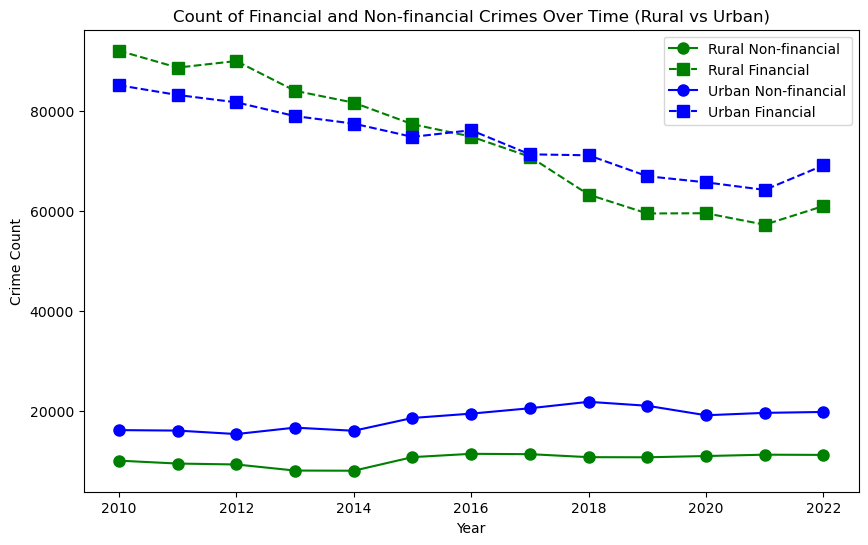

In [63]:
import pandas as pd
import matplotlib.pyplot as plt

#calculating total crimes
crime_per_county['Total Crimes'] = crime_per_county['Non-financial Crimes'] + crime_per_county['Financial Crimes']

#calculating percentages
crime_per_county['Percentage Non-financial'] = (crime_per_county['Non-financial Crimes'] / crime_per_county['Total Crimes']) * 100
crime_per_county['Percentage Financial'] = (crime_per_county['Financial Crimes'] / crime_per_county['Total Crimes']) * 100

#separatiing data for Rural and Urban regions
rural_data = crime_per_county.xs('Rural', level='Region')
urban_data = crime_per_county.xs('Urban', level='Region')

#plotting
fig, ax = plt.subplots(figsize=(10, 6))

#plotting for Rural
ax.plot(rural_data.index.get_level_values('Year'), rural_data['Non-financial Crimes'], label='Rural Non-financial',
        marker='o', linestyle='-', markersize=8, color='green')  # Specify color for Rural Non-financial
ax.plot(rural_data.index.get_level_values('Year'), rural_data['Financial Crimes'], label='Rural Financial',
        marker='s', linestyle='--', markersize=8, color='green')  # Specify color for Rural Financial

#plotting for Urban
ax.plot(urban_data.index.get_level_values('Year'), urban_data['Non-financial Crimes'], label='Urban Non-financial',
        marker='o', linestyle='-', markersize=8, color='blue')  # Specify color for Urban Non-financial
ax.plot(urban_data.index.get_level_values('Year'), urban_data['Financial Crimes'], label='Urban Financial',
        marker='s', linestyle='--', markersize=8, color='blue')  # Specify color for Urban Financial

#adding labels and legend
plt.xlabel('Year')
plt.ylabel('Crime Count')
plt.title('Count of Financial and Non-financial Crimes Over Time (Rural vs Urban)')
plt.legend()
plt.show()


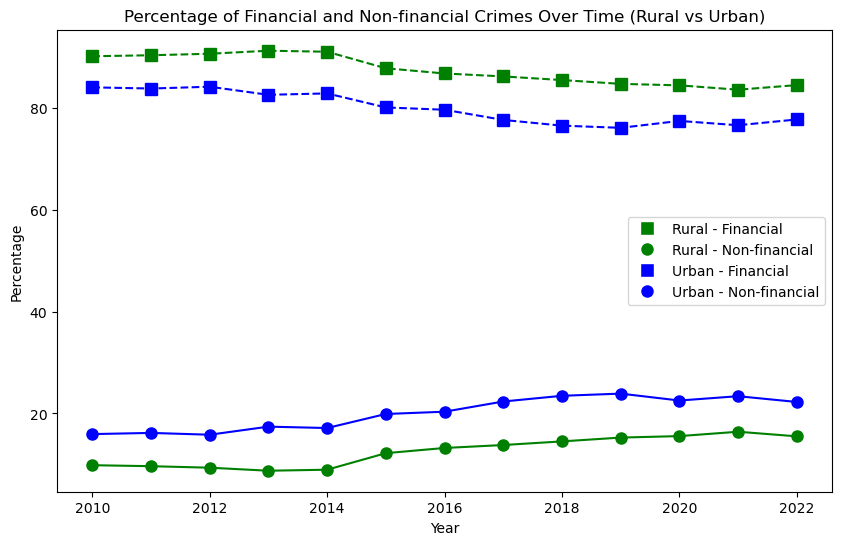

In [64]:
#Making same graph as above (per region of and financial vs non-financial) but as a percentage of the total crimes

from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(10, 6))

#plotting for Rural
ax.plot(rural_data.index.get_level_values('Year'), rural_data['Percentage Non-financial'], label='Rural Non-financial',
        marker='o', linestyle='-', markersize=8, color='green')  # Specify color for Rural Non-financial
ax.plot(rural_data.index.get_level_values('Year'), rural_data['Percentage Financial'], label='Rural Financial',
        marker='s', linestyle='--', markersize=8, color='green')  # Specify color for Rural Financial

#plotting for Urban
ax.plot(urban_data.index.get_level_values('Year'), urban_data['Percentage Non-financial'], label='Urban Non-financial',
        marker='o', linestyle='-', markersize=8, color='blue')  # Specify color for Urban Non-financial
ax.plot(urban_data.index.get_level_values('Year'), urban_data['Percentage Financial'], label='Urban Financial',
        marker='s', linestyle='--', markersize=8, color='blue')  # Specify color for Urban Financial

legend_elements = [Line2D([0], [0], marker='s', color='w', markerfacecolor='green', markersize=10, label='Rural - Financial'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Rural - Non-financial'),
                   Line2D([0], [0], marker='s', color='w', markerfacecolor='blue', markersize=10, label='Urban - Financial'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Urban - Non-financial')]

#adding labels and legend
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.title('Percentage of Financial and Non-financial Crimes Over Time (Rural vs Urban)')
ax.legend(handles=legend_elements)

plt.show()
